In [43]:
#loading yeast groundtruth 0 data
yeast=open("yeast_residual_data_full_1000_gt_2.txt","r")



#yeast data read 
L=[]
A=[]
B=[]
for i in range(0,1000):
    line=yeast.readline()
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=yeast.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=yeast.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=yeast.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_0 = [i for i in zip(L,A,B)]


In [44]:
#loading yeast groundtruth 1 data
yeast=open("yeast_residual_data_full_1000_gt_1.txt","r")



#yeast data read 
L=[]
A=[]
B=[]
for i in range(0,1000):
    line=yeast.readline()
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=yeast.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=yeast.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=yeast.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_1 = [i for i in zip(L,A,B)]

#reshapefunction



In [45]:
#loading the libraries
from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import rpy2

In [46]:
#loading the rpy2 pacakge to use the R package nlcor
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
nlcor=importr('nlcor')
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [47]:
#defining the class MDN
class MDN_module(tf.keras.Model):

    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\", name="+"'h"+str(i)+"')"
          exec(s)
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        x=self.h2(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [48]:
no_parameters=3
components=1
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    """ Evaluate the model to get the loss for the given x and y 
    """
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def reshapevar(X):
  """
  Function to reshape the vector for the input 
  """
  return np.reshape(X,newshape=(len(X),-1))

In [171]:
def compute_loss(P,Q):
    """ Compute the loss for the given pair
    """
    opt = tf.optimizers.Adam(1e-2)
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
    mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
    #return np.array(nlcor.nlcor(P,Q)[0])[0]
    return eval_mdn_model(P,Q,mdn_PQ)


In [50]:
def shuffleBtimes(P,Q,B):
    """ Shuffle Q B times and compute the loss 
    """
    loss=[]
    for i in range(0,B):
      loss.append(compute_loss(P,np.random.permutation(Q)))
    return loss


In [175]:
def LinearLABData():
    """ Generate the linear data 
    """
    L = np.random.binomial(1,0.5,1000)  
    beta0 = np.ones(1000)-0.4
    #beta1 = 0.5
    beta1=3
    beta2= 0.3
    beta3=0.8
    eps0 = np.random.standard_normal(1000)
    eps1 = np.random.standard_normal(1000)
    A = beta0 + beta1*L + eps0
    B = beta2+ beta3*A + eps1 
    plt.scatter(A,B)
    plt.title("A vs B")
    plt.xlabel("A")
    plt.ylabel("B")
    return [L,A,B]

In [52]:
def residual(P,Q):
    """ Calculate the residual 
    """
    opt = tf.optimizers.Adam(1e-2)
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
    #changing epochs didnt make much difference
    mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
    y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))

    #model=sm.OLS(Q,P).fit() 
    #print(model.resid)
    #return model.resid #Linear residual
    #non linear residual
    # print(y_pred)
    #print(Q)
    #print(Q-y_pred[:,1])
    return (Q-y_pred[:,1])


In [53]:
yeast_name=""
def yeast_data(i,ind):
    '''
    Function to return the trios with the gndtruth 0/1 based on i and the number based on ind 
    '''
    global yeast_name
    yeast_name="yeast_"+str(i)+"_"+str(ind)
    ds = eval("dataset_"+str(i)+"["+str(ind)+"]")
    L_dist = np.array(ds[0]) #np.array(ds[0])
    A_dist = np.array(ds[1])
    B_dist = np.array(ds[2])
    plt.scatter(A_dist,B_dist)
    plt.title("A vs B")
    plt.xlabel("A")
    plt.ylabel("B")
    return [L_dist,A_dist,B_dist]

In [54]:
def calculate_pvalue(original,loss_list,test):
    '''
    calculate the p value 
    '''
    if(test==1 or test==2):
        return sum(i < original for i in loss_list)/len(loss_list)
    
    return sum(i > original for i in loss_list)/len(loss_list)
    

In [176]:
def stratify_B_n_times(L,A,B,n):
    '''
    Stratify B wrt to L
    '''
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    for i in range(0,n):

        B_dist_temp=np.zeros(len(B))
        mod_indices_1=random.sample(indices_1,len(indices_1))
        for i in range(len(indices_1)):
            B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

        mod_indices_0=random.sample(indices_0,len(indices_0))
        for i in range(len(indices_0)):
            B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
        #print(B_dist_temp)
        loss.append(compute_loss(L,residual(A,B_dist_temp)))

    return loss 




In [56]:
random.seed(24)

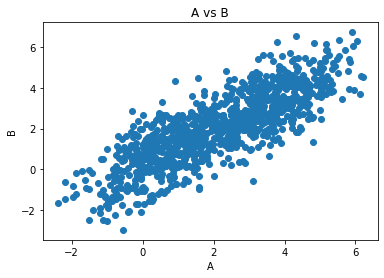

In [177]:

shuffles=10
L,A,B=LinearLABData()
#L,A,B=yeast_data(1,444)


In [178]:

A_shuffle=np.copy(A)
B_shuffle=np.copy(B)
#print("Original",B_shuffle)
loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles)
loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles)
loss_list_Bresidual=stratify_B_n_times(L,A_shuffle,B_shuffle,shuffles) #conditional independence test
true_LA=compute_loss(L,A)
true_LB=compute_loss(L,B)
#print("Next",B_shuffle)
true_LBresidual=compute_loss(L,residual(A,B_shuffle))
print(calculate_pvalue(true_LA,loss_list_LA,1))
print(calculate_pvalue(true_LB,loss_list_LB,2))
print(calculate_pvalue(true_LBresidual,loss_list_Bresidual,3))
#true_LindB_A=compute_loss(L,B_resid)


1.0
1.0
1.0


In [173]:
loss_list_Bresidual

[0.139276417834602,
 0.13506452044067307,
 0.13271214448725788,
 0.12839854024117844,
 0.1504557206279095,
 0.14455605453723985,
 0.12578075592819107,
 0.14108676418667604,
 0.13946274767153988,
 0.14852831066954655]

In [174]:
true_LBresidual

0.13565023298264345

In [27]:
yeast_name 

'yeast_1_444'

In [109]:
pickle_items=[loss_list_LA,loss_list_LB,loss_list_LindB_A,true_LA,true_LB,true_LindB_A]
file_name=str(shuffles)+"shuffles"+yeast_name+".pkl"
open_file = open(file_name, "wb")
pickle.dump(pickle_items, open_file)
open_file.close()


In [37]:
file_name="100shufflesyeast_1_444.pkl"
open_file = open(file_name, "rb")

loaded_list = pickle.load(open_file)

open_file.close()

In [41]:
loss_list_LA,loss_list_LB,loss_list_LindB_A,true_LA,true_LB,true_LindB_A=loaded_list

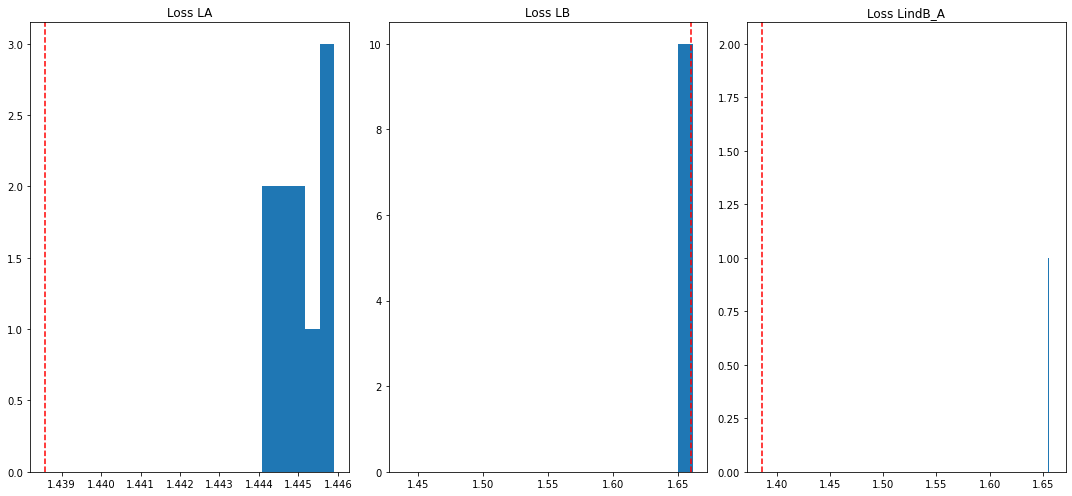

In [103]:
basket=20
fig, axs = plt.subplots(1, 3,figsize =(15, 7),tight_layout = True)
axs[0].hist(loss_list_LA,bins=basket,range=[min(min(loss_list_LA),true_LA),max(max(loss_list_LA),true_LA)])
axs[0].set_title("Loss LA")
axs[0].axvline(true_LA,linestyle='dashed',color='red')
axs[1].hist(loss_list_LB,bins=basket,range=[min(min(loss_list_LA),true_LA),max(max(loss_list_LB),true_LB)])
axs[1].set_title("Loss LB")
axs[1].axvline(true_LB,linestyle='dashed',color='red')
axs[2].hist(loss_list_Bresidual,bins=basket)#,range=[min(min(loss_list_LA),true_LA),max(max(loss_list_LindB_A),true_LindB_A)])
axs[2].set_title("Loss LindB_A")
axs[2].axvline(true_LBresidual,linestyle='dashed',color='red')
plt.show()

In [19]:
#not required now
def calculate_pvalues_conditional_test(L,A,B):
    B_residual=residual(A,B)
    
    return shuffleBtimes(L,B_residual,10)
        
        
    

In [226]:
#DEBUGGING

In [12]:
#A=(A-np.mean(A))/np.std(A)
#B=(B-np.mean(B))/np.std(B)

Text(0, 0.5, 'B residual without strat')

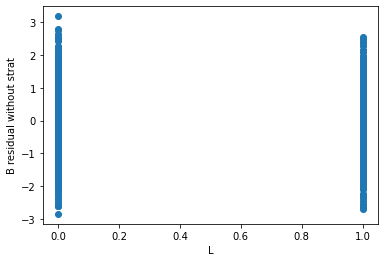

In [146]:
plt.scatter(L,residual(A,B))
plt.xlabel("L")
plt.ylabel("B residual without strat")

In [156]:
nlcor.nlcor(L,residual(A,B))[0]

0.127925


In [157]:
compute_loss(L,residual(A,B))

1.427445

In [149]:
compute_loss(L,B)

1.67342

In [140]:
    opt = tf.optimizers.Adam(1e-2)
    mdn_PQ = MDN_module()
    
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
    #changing epochs didnt make much difference
    mdn_PQ.fit(x=reshapevar(A), y=np.array(B).T,epochs=100,  batch_size=64,verbose=0)
    y_pred = mdn_PQ.predict(np.reshape(A,newshape=(len(A),-1)))

In [124]:
y_pred

array([[ 1.        ,  0.16342524,  0.96256244],
       [ 1.        , -0.6384876 ,  0.9930038 ],
       [ 1.        ,  0.1748625 ,  0.97080135],
       ...,
       [ 1.        ,  1.0291421 ,  0.96818435],
       [ 1.        ,  0.8120367 ,  0.987403  ],
       [ 1.        ,  0.9522828 ,  0.9750506 ]], dtype=float32)

Text(0, 0.5, 'B')

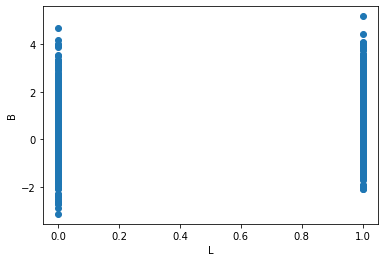

In [148]:
plt.scatter(L,B)
plt.xlabel("L")
plt.ylabel("B")

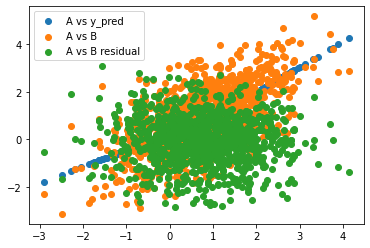

In [144]:
plt.scatter(A,y_pred[:,1],label="A vs y_pred")
plt.scatter(A,B,label="A vs B")
plt.scatter(A,B-y_pred[:,1],label="A vs B residual")
plt.legend(loc="upper left")

In [151]:
indices_1 = [i for i, x in enumerate(L) if x == 1]
indices_0 = [i for i, x in enumerate(L) if x == 0]
B_dist_temp=np.zeros(len(B))
mod_indices_1=random.sample(indices_1,len(indices_1))
for i in range(len(indices_1)):
    B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

mod_indices_0=random.sample(indices_0,len(indices_0))
for i in range(len(indices_0)):
    B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]

In [164]:
    opt = tf.optimizers.Adam(1e-2)
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
    #changing epochs didnt make much difference
    mdn_PQ.fit(x=reshapevar(A), y=np.array(B_dist_temp).T,epochs=100,  batch_size=64,verbose=0)
    y_pred_1 = mdn_PQ.predict(np.reshape(A,newshape=(len(A),-1)))

Text(0, 0.5, 'B residual with strat')

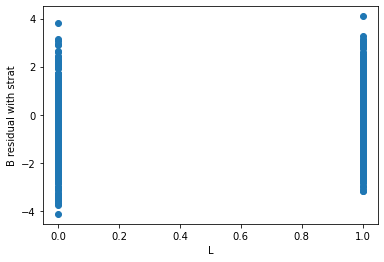

In [154]:
plt.scatter(L,residual(A,B_dist_temp))
plt.xlabel("L")
plt.ylabel("B residual with strat")

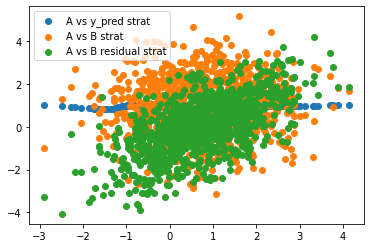

In [165]:
plt.scatter(A,y_pred_1[:,1],label="A vs y_pred strat")
plt.scatter(A,B_dist_temp,label="A vs B strat")
plt.scatter(A,B-y_pred_1[:,1],label="A vs B residual strat")
plt.legend(loc="upper left")

In [166]:
nlcor.nlcor(L,residual(A,B_dist_temp))[0]

0.131839


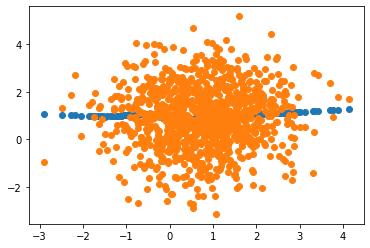

In [158]:
plt.scatter(A,y_pred_1[:,1])
plt.scatter(A,B_dist_temp)
#plt.scatter(A,B-y_pred[:,1])

In [161]:
compute_loss(L,residual(A,B_dist_temp))

1.6708406

In [162]:
compute_loss(L,B_dist_temp)

1.6730556

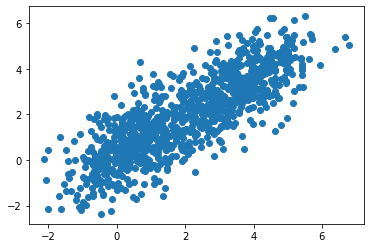

In [71]:
plt.scatter(A,B)

In [119]:
#g=(y_pred[:,1]-np.mean(y_pred[:,1]))/np.std(y_pred[:,1])

In [112]:
#e=B-g

In [144]:
#e=B-y_pred[:,1]

In [145]:
#f=(e-np.mean(e))/np.std(e)

In [72]:
#plt.scatter(A,f)

NameError: name 'f' is not defined

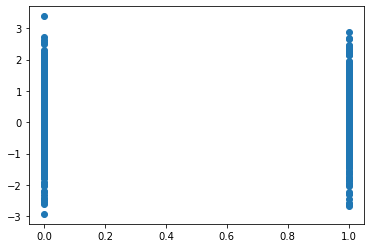

In [73]:
#plt.scatter(L,B-y_pred[:,1])

In [84]:
indices_1 = [i for i, x in enumerate(L) if x == 1]
indices_0 = [i for i, x in enumerate(L) if x == 0]
B_dist_temp=np.zeros(len(B))
mod_indices_1=random.sample(indices_1,len(indices_1))
for i in range(len(indices_1)):
    B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

mod_indices_0=random.sample(indices_0,len(indices_0))
for i in range(len(indices_0)):
    B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]

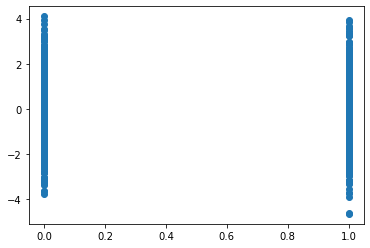

In [85]:
plt.scatter(L,B_dist_temp-y_pred[:,1])

In [723]:
a=sm.OLS(B,A).fit()
a.predict()

array([-6.31027548e-01,  1.04117398e+00, -1.15092817e+00,  5.18809844e-01,
       -4.91571692e-01, -7.89234233e-01, -9.53893493e-01, -9.88380970e-01,
       -2.51158781e-01,  8.76646390e-01,  9.12551035e-01, -6.49964987e-01,
        5.28907553e-01, -5.19468946e-01, -5.61195914e-01,  5.46353601e-01,
       -6.30876933e-01, -1.65866469e-01,  1.15108098e+00,  1.01766572e+00,
        7.26309420e-01,  3.09734021e-01, -1.48833253e+00, -4.29133411e-01,
       -6.50000004e-01, -7.01593031e-01, -1.62885584e+00,  1.32449699e+00,
        1.73260120e-01, -1.07835162e+00,  1.39360873e-01,  1.85730125e+00,
       -5.59015391e-01, -1.61102421e-01,  7.07313914e-01,  5.92045175e-01,
        8.09402026e-01,  4.56142864e-01,  7.38121867e-01, -1.15332608e+00,
       -1.01719730e+00, -1.32116871e+00, -8.26183011e-01,  1.95773448e-01,
        7.49148753e-02, -1.10003687e+00,  8.04283878e-01,  1.99338477e-01,
        3.19364449e-01, -8.17653431e-01, -5.66504765e-01, -5.09234207e-01,
        9.76752657e-01, -

In [724]:
#c=(a.resid-np.mean(a.resid))/np.std(a.resid)

Text(0, 0.5, 'B residual')

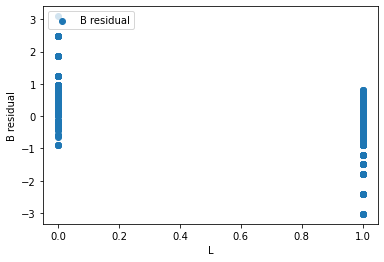

In [659]:
plt.scatter(L,c,label="B residual")
plt.legend(loc="upper left")
plt.xlabel("L")
plt.ylabel("B residual")

In [74]:
indices_1 = [i for i, x in enumerate(L) if x == 1]
indices_0 = [i for i, x in enumerate(L) if x == 0]
B_dist_temp=np.zeros(len(B))
mod_indices_1=random.sample(indices_1,len(indices_1))
for i in range(len(indices_1)):
    B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

mod_indices_0=random.sample(indices_0,len(indices_0))
for i in range(len(indices_0)):
    B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]

In [148]:
#B_dist_temp=(B_dist_temp-np.mean(B_dist_temp))/ np.std(B_dist_temp)

In [75]:
    opt = tf.optimizers.Adam(1e-2)
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
    #changing epochs didnt make much difference
    mdn_PQ.fit(x=reshapevar(A), y=np.array(B_dist_temp).T,epochs=100,  batch_size=64,verbose=0)
    y_pred_1 = mdn_PQ.predict(np.reshape(A,newshape=(len(A),-1)))

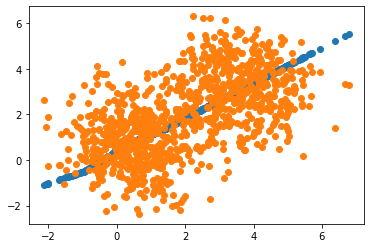

In [81]:
plt.scatter(A,y_pred[:,1])
plt.scatter(A,B_dist_temp)
#plt.scatter(A,B)

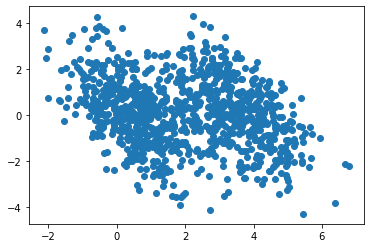

In [83]:
plt.scatter(A,B_dist_temp-y_pred[:,1])

In [126]:
#i= (y_pred_1[:,1]-np.mean(y_pred_1[:,1]))/np.std(y_pred_1[:,1])

In [38]:
#h=B-i

In [150]:
#h=B-y_pred_1[:,1]

In [151]:
#h=(h-np.mean(h))/np.std(h)

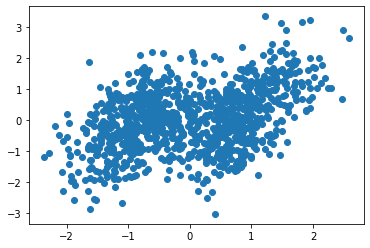

In [97]:
plt.scatter(A,h)

In [152]:
compute_loss(L,h)

1.4028442

Text(0, 0.5, 'B_stratified')

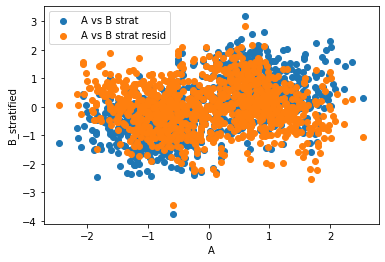

In [730]:
plt.scatter(A,B_dist_temp,label="A vs B strat")
b=sm.OLS(B_dist_temp,A).fit()
#plt.scatter(A,b.predict())
plt.scatter(A,b.resid,label="A vs B strat resid")
plt.legend(loc="upper left")
plt.xlabel("A")
plt.ylabel("B_stratified")


In [731]:
#d=(b.resid-np.mean(b.resid))/np.std(b.resid)

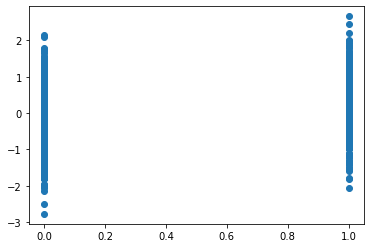

In [717]:
#plt.scatter(L,b.resid)

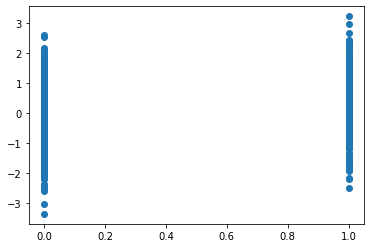

In [718]:
#plt.scatter(L,d)

In [732]:
#compute_loss(L,d)

1.3784499

Text(0, 0.5, 'B')

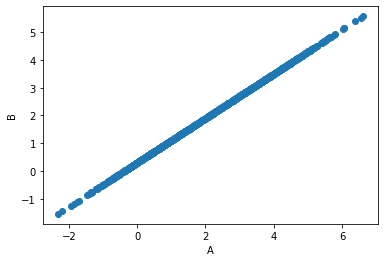

In [570]:
#plt.scatter(A,B)
#plt.xlabel("A")
#plt.ylabel("B")

Text(0, 0.5, 'Bresid')

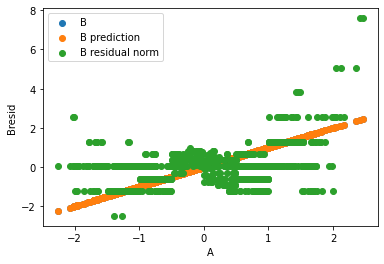

In [613]:
#plt.scatter(A,B,label="B")

#plt.scatter(A,a.predict(),label="B prediction")
#plt.scatter(A,c,label="B residual norm")
#plt.legend(loc="upper left")
#plt.xlabel("A")
#plt.ylabel("Bresid")

Text(0, 0.5, 'B residual')

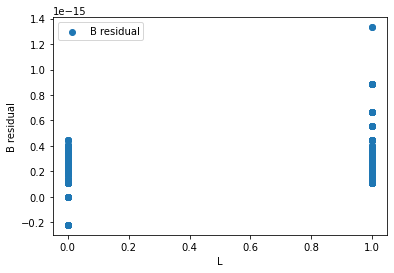

In [600]:
#plt.scatter(L,a.resid,label="B residual")
#plt.legend(loc="upper left")
#plt.xlabel("L")
#plt.ylabel("B residual")

In [620]:
#compute_loss(L,c)

1.3125007

In [95]:
#plt.scatter(L,B_residual)

NameError: name 'B_residual' is not defined

In [124]:
#B_dist_temp

array([-9.61627908e-01, -1.10987128e+00,  1.23594298e+00,  9.51786163e-01,
        1.78798696e-01, -7.08903956e-01,  9.04673428e-01,  1.67806443e+00,
       -3.12542720e-01,  5.89729704e-01,  1.67647477e+00,  1.85233128e+00,
       -1.28530702e+00,  1.03951114e+00,  1.02464178e+00, -1.13872893e+00,
        1.39728568e+00, -9.30813494e-01, -1.88193544e+00,  1.51190791e+00,
        4.27604350e-01, -2.94129654e-02, -1.64304860e+00, -1.69332798e+00,
        3.67690390e-01,  2.16541102e+00,  9.49091833e-01, -6.55471492e-01,
       -5.86883837e-01,  7.74895786e-02, -4.73596315e-02,  1.02526812e+00,
       -1.86028430e+00, -7.30139335e-01,  7.56503009e-01, -1.53394551e+00,
       -1.17904774e+00,  1.15446708e+00, -1.01122549e+00, -8.86258129e-01,
       -5.18352333e-01, -7.64146001e-02,  1.53218411e+00, -8.53808330e-01,
        1.16225076e+00,  8.29640982e-01,  1.41523746e+00,  1.31328698e+00,
        1.22792991e+00,  6.65406359e-01, -5.68730640e-01,  6.67151810e-01,
        1.07561707e+00, -

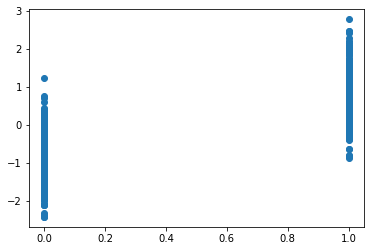

In [135]:
#plt.scatter(L,B_dist_temp)

Text(0, 0.5, 'B_strat residual')

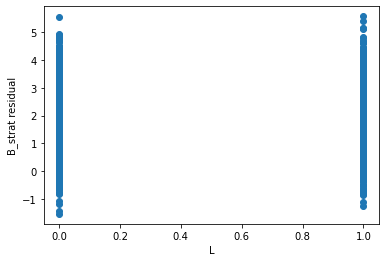

In [603]:
#plt.scatter(L,b.resid)
#plt.xlabel("L")
#plt.ylabel("B_strat residual")

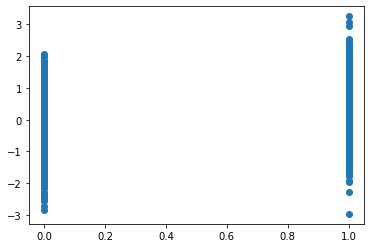

In [621]:
#plt.scatter(L,d)

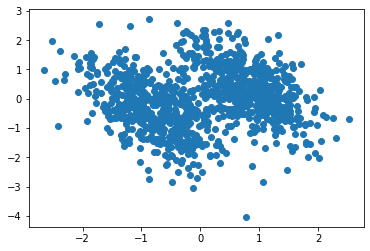

In [142]:
#plt.scatter(A,d)

In [604]:
#compute_loss(L,b.resid)

1.7951493

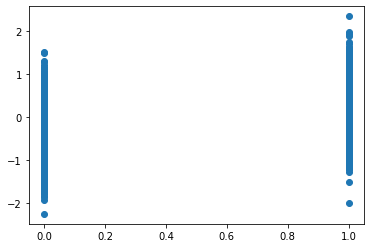

In [82]:
#plt.scatter(L,b.resid)

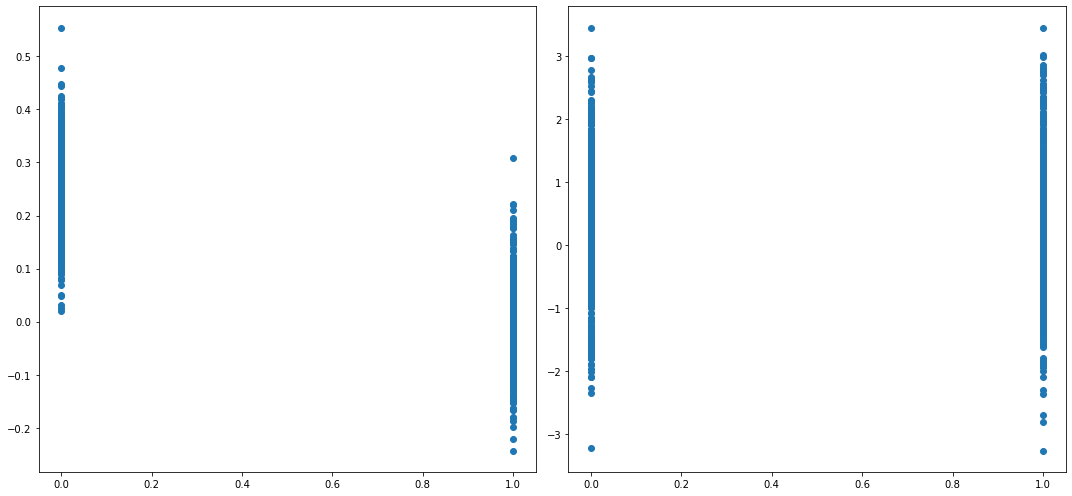

In [68]:

#fig, axs = plt.subplots(1, 2,figsize =(15, 7),tight_layout = True)
#axs[0].scatter(L,a.resid)
#axs[1].scatter(L,b.resid)

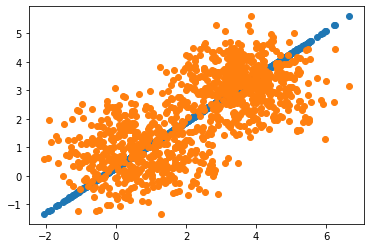

In [68]:
#plt.scatter(A,B)
#plt.scatter(A,B_dist_temp)

In [15]:
#residual(A,B)

[-2.54210067e-01  5.42629652e-01 -5.81969778e-01  4.59890495e-01
  1.99993533e-01 -1.03758464e+00  2.36681237e-01 -4.11425390e-01
 -3.80602961e-01  4.89073048e-01  5.07861036e-01 -5.20122483e-01
  1.37835804e+00  9.49590006e-01  5.39468445e-01 -9.18726624e-01
 -1.59540767e-01  1.74380009e+00  7.83707277e-01 -1.04954102e+00
 -8.34245116e-01 -1.13423210e+00 -2.82287175e-01 -1.19861343e+00
  2.67186626e-01  2.45780254e-01 -1.22017037e+00  5.66641735e-01
  9.50850422e-01 -2.03615644e+00 -5.96837362e-01  3.25956226e-01
 -2.08223068e-01 -5.95957379e-02 -1.78095998e+00  2.25890803e+00
  1.45119923e+00 -4.41864111e-01  8.98598331e-01  2.02511735e+00
 -8.32015348e-01 -9.50132975e-01  9.38607866e-01 -7.81604616e-01
  3.93113321e-02  1.85973935e-02  2.42923241e-01  2.24870215e-01
 -9.66476615e-01 -1.52967211e+00 -7.10941492e-01 -6.60564770e-01
  5.82869782e-01  5.08140089e-02  1.79171854e+00  6.28931976e-01
  7.28517866e-01 -9.87147310e-01 -4.23925735e-01  6.03460261e-01
 -1.27473816e+00  9.19610

array([-2.54210067e-01,  5.42629652e-01, -5.81969778e-01,  4.59890495e-01,
        1.99993533e-01, -1.03758464e+00,  2.36681237e-01, -4.11425390e-01,
       -3.80602961e-01,  4.89073048e-01,  5.07861036e-01, -5.20122483e-01,
        1.37835804e+00,  9.49590006e-01,  5.39468445e-01, -9.18726624e-01,
       -1.59540767e-01,  1.74380009e+00,  7.83707277e-01, -1.04954102e+00,
       -8.34245116e-01, -1.13423210e+00, -2.82287175e-01, -1.19861343e+00,
        2.67186626e-01,  2.45780254e-01, -1.22017037e+00,  5.66641735e-01,
        9.50850422e-01, -2.03615644e+00, -5.96837362e-01,  3.25956226e-01,
       -2.08223068e-01, -5.95957379e-02, -1.78095998e+00,  2.25890803e+00,
        1.45119923e+00, -4.41864111e-01,  8.98598331e-01,  2.02511735e+00,
       -8.32015348e-01, -9.50132975e-01,  9.38607866e-01, -7.81604616e-01,
        3.93113321e-02,  1.85973935e-02,  2.42923241e-01,  2.24870215e-01,
       -9.66476615e-01, -1.52967211e+00, -7.10941492e-01, -6.60564770e-01,
        5.82869782e-01,  